In [1]:
import os
import time
import nibabel as nb
import numpy as np
import pandas as pd
from scipy import ndimage
import h5py
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import multiprocessing


def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p], p

true_array = [np.array((x,y,z)) for x in range(58,63) for y in range(48,53) for z in range(63,68)]

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [2]:
X_shfl = np.load('output/X_shfl.npz')['data']
ac_shfl = np.load('output/ac_shfl.npz')['data']
cc_shfl = np.load('output/cc_shfl.npz')['data']
X_shfl, ac_shfl, cc_shfl, order = unison_shuffled_copies(X_shfl, ac_shfl, cc_shfl)

In [4]:
X_tfce_shfl = np.load('output/X_tfce_shfl.npy')
tc_shfl = np.load('output/tfce_cutoff_shfl.npy')
X_tfce_shfl, tc_shfl, _, order = unison_shuffled_copies(X_tfce_shfl, tc_shfl, tc_shfl)

In [5]:
xgb_ale = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count() // 2)
xgb_ale = xgb_ale.fit(X_shfl, ac_shfl)

xgb_cluster = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count() // 2)
xgb_cluster = xgb_cluster.fit(X_shfl, cc_shfl)

xgb_tfce = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count() // 2)
xgb_tfce = xgb_tfce.fit(X_tfce_shfl, tc_shfl)


In [6]:
xgb_ale.save_model('output/vFWE_model.txt')
xgb_cluster.save_model('output/cFWE_model.txt')
xgb_tfce.save_model('output/tfce_model.txt')

In [7]:
X_real = pd.read_csv('output/x_real.csv')
vc_real = X_real['v_cutoff'].values * 100
cc_real = X_real['c_cutoff'].values
tc_real = X_real['t_cutoff'].values

In [8]:
vc_predict_xgb = []
cc_predict_xgb = []
tc_predict_xgb = []

for idx, row in X_real.iterrows():
    vc_predict_xgb.append(xgb_ale.predict(row[4:].values.reshape(1,26))[0] * 100)
    cc_predict_xgb.append(xgb_cluster.predict(row[4:].values.reshape(1,26))[0])
    tc_predict_xgb.append(xgb_tfce.predict(row[4:].values.reshape(1,26))[0])
    
cc_predict_xgb = np.round(cc_predict_xgb)

r2_voxel = np.round(r2_score(vc_real, vc_predict_xgb), 3)
r2_cluster = np.round(r2_score(cc_real, cc_predict_xgb), 3)
r2_tfce = np.round(r2_score(tc_real, tc_predict_xgb), 3)

In [9]:
mask = np.ones((21,), dtype=bool)
mask[16] = 0

r2_voxel_or = np.round(r2_score(vc_real[mask], np.array(vc_predict_xgb)[mask]), 3)
r2_cluster_or = np.round(r2_score(cc_real[mask], cc_predict_xgb[mask]), 3)
r2_tfce_or = np.round(r2_score(tc_real[mask], np.array(tc_predict_xgb)[mask]), 3)

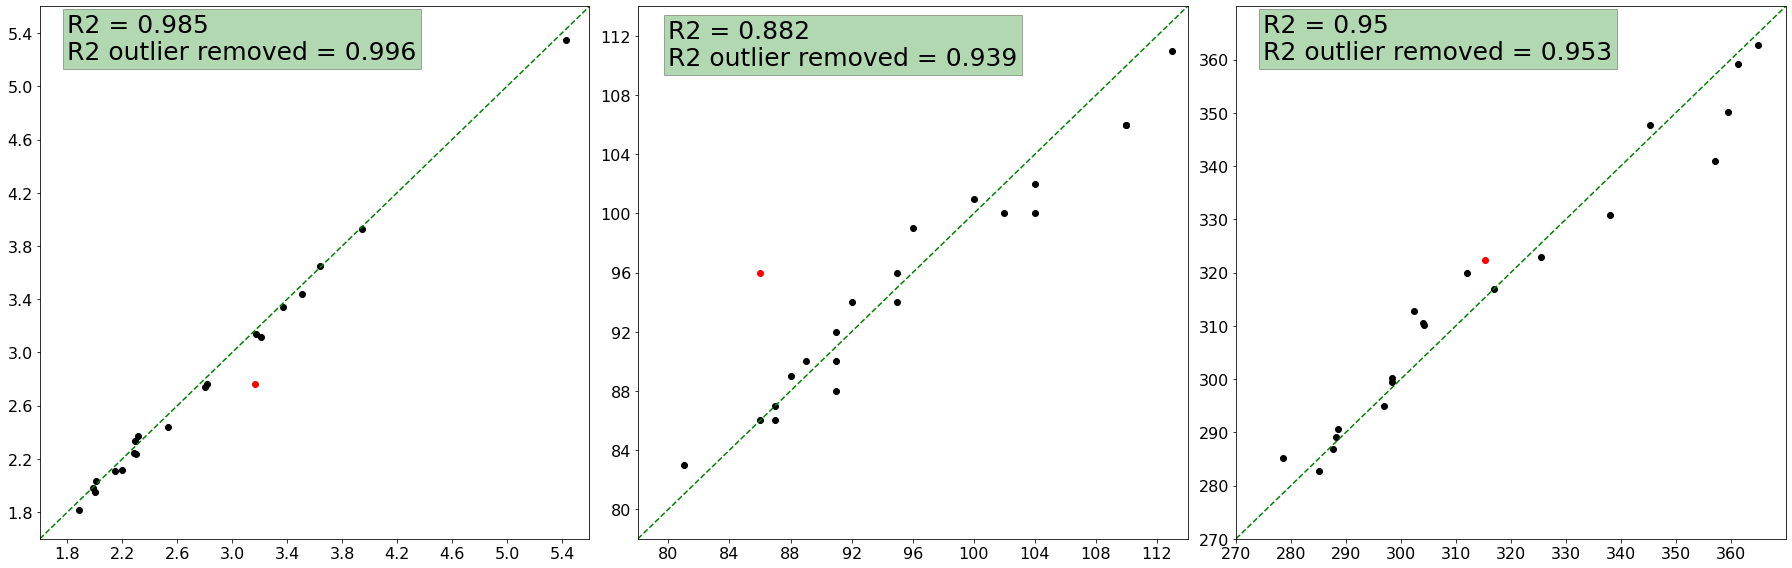

In [12]:
fig, ax = plt.subplots(1,3, figsize=(25,8))
for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=16)
    axs.tick_params(axis='both', which='minor', labelsize=14)

for i in range(len(vc_real)):
    if i == 16:
         ax[0].scatter(vc_real[i],np.array(vc_predict_xgb)[i], color='red')
    else:
        ax[0].scatter(vc_real[i],np.array(vc_predict_xgb)[i], color='black')
ax[0].set_xlim(1.6,5.6)
ax[0].set_ylim(1.6,5.6)
ax[0].set_xticks(np.arange(1.8,5.6,0.4))
ax[0].set_yticks(np.arange(1.8,5.6,0.4))
add_identity(ax[0], color='green', ls='--')

ax[0].text(1.8, 5.2, f'R2 = {r2_voxel} \nR2 outlier removed = {r2_voxel_or}', fontsize = 25, 
         bbox = dict(facecolor = 'green', alpha = 0.3))


for i in range(len(cc_real)):
    if i == 16:
         ax[1].scatter(cc_real[i],np.array(cc_predict_xgb)[i], color='red')
    else:
        ax[1].scatter(cc_real[i],np.array(cc_predict_xgb)[i], color='black')
ax[1].set_xlim(78,114)
ax[1].set_ylim(78,114)
ax[1].set_xticks(np.arange(80,114,4))
ax[1].set_yticks(np.arange(80,114,4))
add_identity(ax[1], color='g', ls='--')

ax[1].text(80, 110, f'R2 = {r2_cluster} \nR2 outlier removed = {r2_cluster_or}', fontsize = 25, 
         bbox = dict(facecolor = 'green', alpha = 0.3))
fig.tight_layout()



for i in range(len(tc_real)):
    if i == 16:
        ax[2].scatter(tc_real[i],np.array(tc_predict_xgb)[i], color='red')
    else:
        ax[2].scatter(tc_real[i],np.array(tc_predict_xgb)[i], color='black')
ax[2].set_xlim(270,370)
ax[2].set_ylim(270,370)
ax[2].set_xticks(np.arange(270,370,10))
ax[2].set_yticks(np.arange(270,370,10))
add_identity(ax[2], color='g', ls='--')

ax[2].text(275, 360, f'R2 = {r2_tfce} \nR2 outlier removed = {r2_tfce_or}', fontsize = 25, bbox = dict(facecolor = 'green', alpha = 0.3))
fig.tight_layout()

In [22]:
tfce_top5

n_foci_total    0.810524
n_exp           0.102565
vli_foci        0.029272
li_foci         0.025465
mi_foci         0.011219
dtype: float32

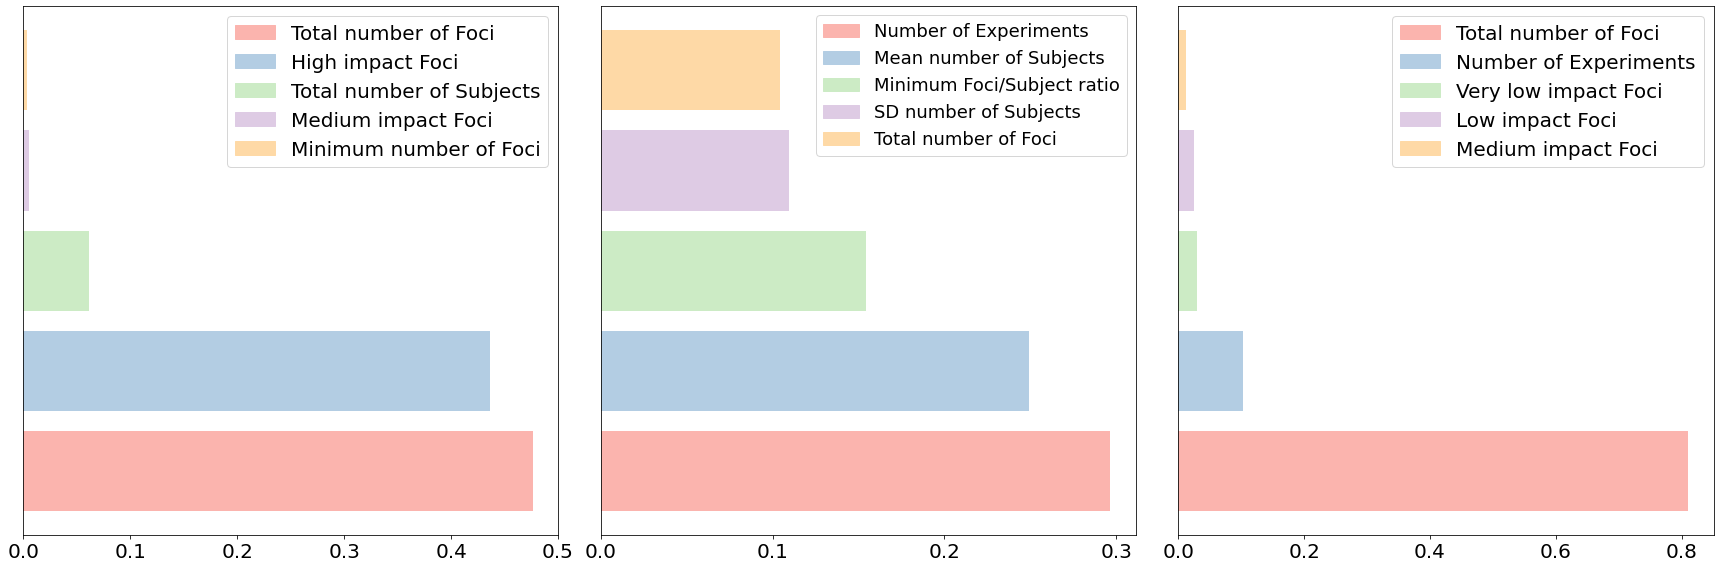

In [23]:
ale_importances = pd.Series(xgb_ale.feature_importances_, index=X_real.columns[4:])
ale_top5 = ale_importances.nlargest(5)

cluster_importances = pd.Series(xgb_cluster.feature_importances_, index=X_real.columns[4:])
cluster_top5 = cluster_importances.nlargest(5)

tfce_importances = pd.Series(xgb_tfce.feature_importances_, index=X_real.columns[4:])
tfce_top5 = tfce_importances.nlargest(5)

fig, ax = plt.subplots(1,3,figsize=(24,8))
my_cmap = plt.get_cmap("Pastel1")
ax[0].barh(y=ale_top5.index, width=ale_top5.values, color=my_cmap.colors)
ax[0].set_yticks([])
ax[0].set_xticks(np.arange(0,0.51,0.1))
ax[0].set_xticklabels(np.round(np.arange(0,0.51,0.1),3), fontsize=20)

labels=ale_top5.index
handles = [plt.Rectangle((0,0),1,1, color=my_cmap.colors[i]) for i,label in enumerate(labels)]
ax[0].legend(handles, ['Total number of Foci', 'High impact Foci', 'Total number of Subjects','Medium impact Foci', 'Minimum number of Foci'], fontsize=20)

ax[1].barh(y=cluster_top5.index, width=cluster_top5.values, color=my_cmap.colors)
ax[1].set_yticks([])
ax[1].set_xticks(np.arange(0,0.351,0.1))
ax[1].set_xticklabels(np.round(np.arange(0,0.351,0.1),3), fontsize=20)

labels=cluster_top5.index
handles = [plt.Rectangle((0,0),1,1, color=my_cmap.colors[i]) for i,label in enumerate(labels)]
ax[1].legend(handles, ['Number of Experiments', 'Mean number of Subjects', 'Minimum Foci/Subject ratio', 'SD number of Subjects', 'Total number of Foci'], fontsize=18)


ax[2].barh(y=tfce_top5.index, width=tfce_top5.values, color=my_cmap.colors)
ax[2].set_yticks([])
ax[2].set_xticks(np.arange(0,0.91,0.2))
ax[2].set_xticklabels(np.round(np.arange(0,0.91,0.2),3), fontsize=20)

labels=tfce_top5.index
handles = [plt.Rectangle((0,0),1,1, color=my_cmap.colors[i]) for i,label in enumerate(labels)]
ax[2].legend(handles, ['Total number of Foci', 'Number of Experiments', 'Very low impact Foci', 'Low impact Foci', 'Medium impact Foci'], fontsize=20)

fig.tight_layout()

Text(0, 0.5, 'Minutes of compute time')

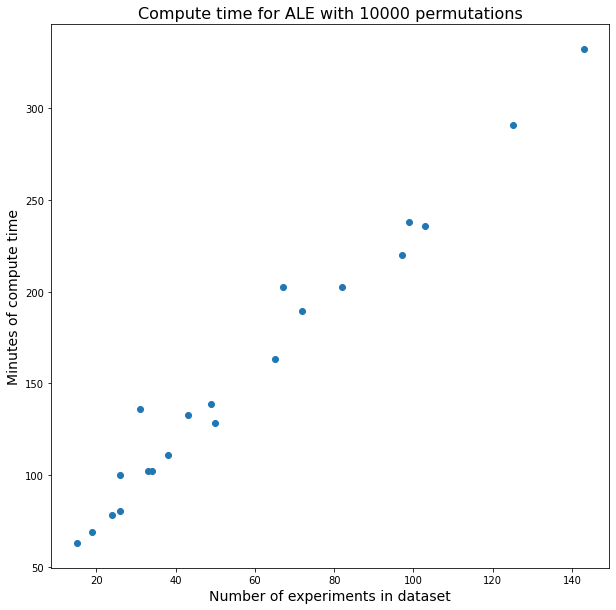

In [25]:
time = [128.56863092978796, 237.93227049907046, 102.25137548446654, 138.4927173455556, 163.28320978085202, 68.79846826394399, 110.79441914955775, 102.28411600589752, 77.96509635448457, 235.53944668372475, 189.23974001407626, 332.19757329225547, 290.7652847448985, 202.5998553752899, 132.59901638428371, 202.46091024080914, 135.8524019241333, 99.82729297876358, 62.911476047833766, 80.50147227048873, 219.76797833840055]


fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(X_real.n_exp, time)
ax.set_title('Compute time for ALE with 10000 permutations', fontsize=16)
ax.set_xlabel('Number of experiments in dataset', fontsize=14)
ax.set_ylabel('Minutes of compute time', fontsize=14)